# Autoencoder
* [Generate Polynomial 2-dim Images](#1)
* [Train Autoencoders](#2)
* [Visualize Latent dimensions and PCA, t-SNE](#3)
* [Quadratic Polynomials](#4)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Generate Polynomial Images <a class='anchor' id=1></a>

In [2]:
def polynomial_image(n, pixels):
    '''Create an array-image of size (pixels, pixels) out of a random 2-dim polynomial
    of degree n
    '''
    # a polynomial of two variables has (n+1)^2 coefficients
    # make random coefficients in [0, 1] of the shape (n+1, n+1)
    coef = np.random.uniform(-1, 1, (n+1, n+1))
    
    image_poly = np.zeros((pixels, pixels))
    for x in range(pixels):
        for y in range(pixels):
            poly_xy = 0
            for i in range(n+1):
                for j in range(n+1):
                    if i+j<=n:
                        poly_xy += coef[i, j]*x**i*y**j 
            image_poly[x, y] = poly_xy
            
    return image_poly

In [3]:
# generate of dataset of size n_data, of images (pixel, pixel), of polynomial up to degree max_degree
n_data, pixel, max_degree = 5000, 28, 4
# do not include constant polynomials
data = np.array([polynomial_image(np.random.randint(1, max_degree+1), pixel) for _ in range(n_data)])  
# normalize the data
data = keras.utils.normalize(data)

In [4]:
n_train = 4500 
n_test = n_data - n_train
x_train, x_test = data[:n_train], data[n_train:]
print(f'shape of the data is {x_train.shape}, test data {x_test.shape}')

shape of the data is (4500, 28, 28), test data (500, 28, 28)


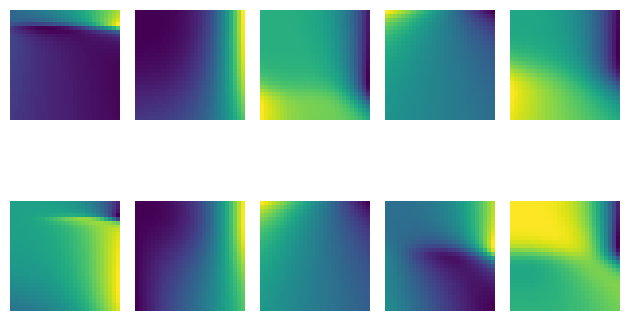

In [7]:
# visualize some of the data
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[np.random.randint(4500)],
               )
    plt.axis('off')

plt.tight_layout()
plt.show()

## Build two Autoencoder <a class='anchor' id=2></a>

In [8]:
# build an Autoencoder with just one hidden layer of latent dimension 2

input = keras.layers.Input(shape=(pixel**2,))
hidden = keras.layers.Dense(2, activation='linear')(input)

# create also the latent Model to visualize the latent dimensions
latent_model_simple = keras.Model(inputs = input, outputs = hidden)

output = keras.layers.Dense(pixel**2, activation='linear')(hidden)

autoencoder_simple = keras.Model(inputs = input, outputs = output)
autoencoder_simple.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder_simple.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         1,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │         2,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,922 (15.32 KB)

 Trainable params: 3,922 (15.32 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history1 = autoencoder_simple.fit(x_train.reshape(n_train, -1), 
                       x_train.reshape(n_train, -1),
                       validation_data = (x_test.reshape(n_test, -1), x_test.reshape(n_test, -1)),
                       epochs = 10,
                       batch_size = 32,
                       verbose = 1,
                       )

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -0.2857 - val_loss: -0.5990
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.6991 - val_loss: -0.7289
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.7680 - val_loss: -0.7845
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.8213 - val_loss: -0.7850
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.8418 - val_loss: -0.8271
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.8707 - val_loss: -0.8475
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -0.8801 - val_loss: -0.8539
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.8542 - val_loss: -0.8610
Epoch 9/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.9186 - val_loss: -0.8652
Epoch 10/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.9191 - val_loss: -0.8656


In [12]:
# build an Autoencoder with just several hidden layers

input = keras.layers.Input(shape=(pixel**2,))
encoder1 = keras.layers.Dense(100, activation='relu')(input)
encoder2 = keras.layers.Dense(50, activation='relu')(encoder1)

latent = keras.layers.Dense(2, activation='linear')(encoder2)

latent_model_complex = keras.Model(inputs = input, outputs = latent)

dencoder1 = keras.layers.Dense(50, activation='relu')(latent)
dencoder2 = keras.layers.Dense(100, activation='relu')(dencoder1)
output = keras.layers.Dense(pixel**2, activation='linear')(dencoder2)

autoencoder_complex = keras.Model(inputs = input, outputs = output)
autoencoder_complex.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder_complex.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           102 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 784)            │        79,184 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,086 (656.59 KB)

 Trainable params: 168,086 (656.59 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history2 = autoencoder_complex.fit(x_train.reshape(n_train, -1), 
                       x_train.reshape(n_train, -1),
                       validation_data = (x_test.reshape(n_test, -1), x_test.reshape(n_test, -1)),
                       epochs = 10,
                       batch_size = 32,
                       verbose = 1,
                       )

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: -0.4441 - val_loss: -0.6164
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: -0.6676 - val_loss: -0.6371
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.6878 - val_loss: -0.6446
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: -0.7170 - val_loss: -0.6591
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: -0.6683 - val_loss: -0.6601
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: -0.6956 - val_loss: -0.6694
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: -0.7084 - val_loss: -0.6732
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: -0.6963 - val_loss: -0.6688
Epoch 9/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -0.7178 - val_loss: -0.6869
Epoch 10/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -0.7358 - val_loss: -0.6923


## Visualize Latent Space Data and compare with PCA and t-SNE <a class='hidden' id=3></a>

In [20]:
# use PCA
pca_model = PCA(n_components=2, svd_solver='full')
pca_latent_data = pca_model.fit_transform(x_train.reshape(n_train, -1))

# use TSNE
tsne_model = TSNE(n_components=2, perplexity=25, )
tsne_latent_data = tsne_model.fit_transform(x_train.reshape(n_train, -1))

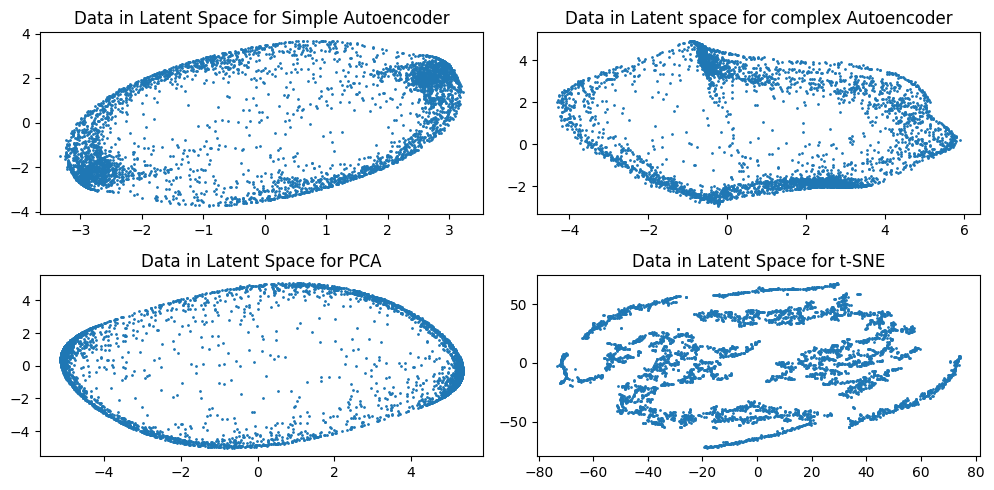

In [27]:
plt.figure(figsize= (10, 5))
latent_data_simple = latent_model_simple(x_train.reshape(n_train, -1))
plt.subplot(2, 2, 1)
plt.scatter(latent_data_simple[:, 0], latent_data_simple[:, 1], s=1)
plt.title('Data in Latent Space for Simple Autoencoder')
# plt.show()

plt.subplot(2, 2, 2)
latent_data = latent_model_complex(x_train.reshape(n_train, -1))
plt.scatter(latent_data[:, 0], latent_data[:, 1], s=1)
plt.title('Data in Latent space for complex Autoencoder')
# plt.show()

plt.subplot(2, 2, 3)
plt.scatter(pca_latent_data[:, 0], pca_latent_data[:, 1], s=1)
plt.title('Data in Latent Space for PCA')
# plt.show()

plt.subplot(2, 2, 4)
plt.scatter(tsne_latent_data[:, 0], tsne_latent_data[:, 1], s=1)
plt.title('Data in Latent Space for t-SNE')
plt.tight_layout()
plt.show()

## Use only quadratic polynomials <a class='anchor' id='4'></a>

In [28]:
# generate of dataset of size n_data, of images (pixel, pixel), of polynomial up to degree max_degree
n_data, pixel= 5000, 28
# do not include constant polynomials
data = np.array([polynomial_image(2, pixel) for _ in range(n_data)])  
# normalize the data
data = keras.utils.normalize(data)

In [29]:
n_train = 4500 
n_test = n_data - n_train
x_train, x_test = data[:n_train], data[n_train:]
print(f'shape of the data is {x_train.shape}, test data {x_test.shape}')

shape of the data is (4500, 28, 28), test data (500, 28, 28)


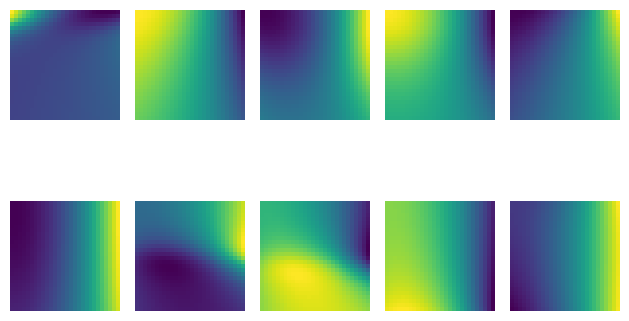

In [30]:
# visualize some of the data
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[np.random.randint(4500)],
               )
    plt.axis('off')

plt.tight_layout()
plt.show()

In [31]:
autoencoder_simple.fit(x_train.reshape(n_train, -1), 
                       x_train.reshape(n_train, -1),
                       validation_data = (x_test.reshape(n_test, -1), x_test.reshape(n_test, -1)),
                       epochs = 10,
                       batch_size = 32,
                       verbose = 1,
                       )

autoencoder_complex.fit(x_train.reshape(n_train, -1), 
                       x_train.reshape(n_train, -1),
                       validation_data = (x_test.reshape(n_test, -1), x_test.reshape(n_test, -1)),
                       epochs = 10,
                       batch_size = 32,
                       verbose = 1,
                       )

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.9251 - val_loss: -1.0443
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.9523 - val_loss: -1.0483
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.9211 - val_loss: -1.0493
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.9253 - val_loss: -1.0572
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.9358 - val_loss: -1.0585
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.9495 - val_loss: -1.0591
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.9817 - val_loss: -1.0623
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.9372 - val_loss: -1.0631
Epoch 9/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.9698 - val_loss: -1.0609
Epoch 10/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.9517 - val_loss: -1.0662
Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: -0.7311 - val_loss: -0.8929
Epoch 2/10
141/141 ━━━━━━━━━━━━

In [32]:
# use PCA
pca_model = PCA(n_components=2, svd_solver='full')
pca_latent_data = pca_model.fit_transform(x_train.reshape(n_train, -1))

# use TSNE
tsne_model = TSNE(n_components=2, perplexity=25, )
tsne_latent_data = tsne_model.fit_transform(x_train.reshape(n_train, -1))

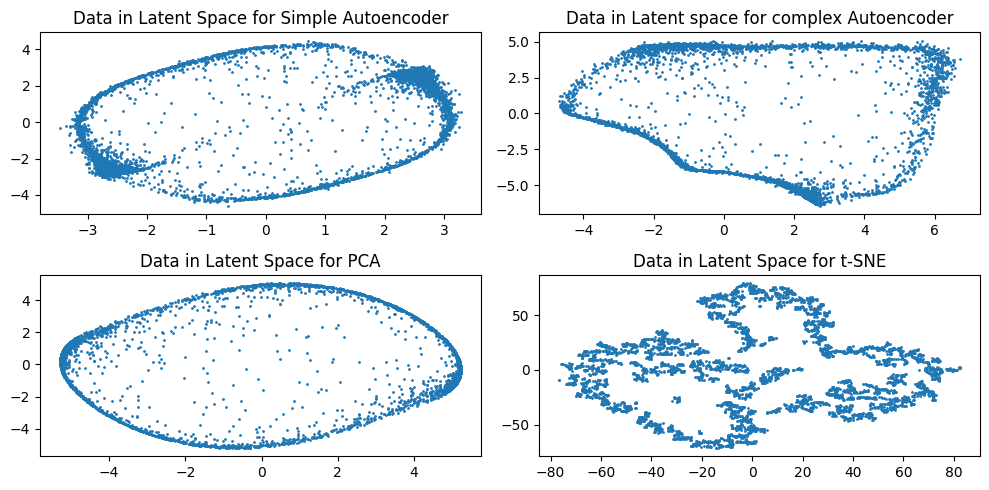

In [33]:
plt.figure(figsize= (10, 5))
latent_data_simple = latent_model_simple(x_train.reshape(n_train, -1))
plt.subplot(2, 2, 1)
plt.scatter(latent_data_simple[:, 0], latent_data_simple[:, 1], s=1)
plt.title('Data in Latent Space for Simple Autoencoder')
# plt.show()

plt.subplot(2, 2, 2)
latent_data = latent_model_complex(x_train.reshape(n_train, -1))
plt.scatter(latent_data[:, 0], latent_data[:, 1], s=1)
plt.title('Data in Latent space for complex Autoencoder')
# plt.show()

plt.subplot(2, 2, 3)
plt.scatter(pca_latent_data[:, 0], pca_latent_data[:, 1], s=1)
plt.title('Data in Latent Space for PCA')
# plt.show()

plt.subplot(2, 2, 4)
plt.scatter(tsne_latent_data[:, 0], tsne_latent_data[:, 1], s=1)
plt.title('Data in Latent Space for t-SNE')
plt.tight_layout()
plt.show()